# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

<ipython-input-6-13b4d9c7a4be>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])


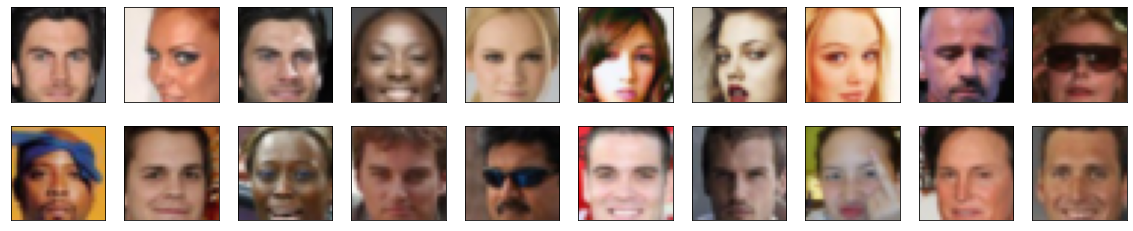

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    return x * (max - min) + min # x * 2 - 1

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.8667)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # 32*32 -> 16*16 image
        self.conv2 = conv(conv_dim, conv_dim*2, 4)          # 16*16 -> 8*8 image
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)        # 8*8   -> 4*4 image
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(-1, self.conv_dim*4*4*4)
        x = self.fc(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)    # 4*4 -> 8*8 image
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)      # 8*8 -> 16*16 image
        self.deconv3 = deconv(conv_dim, 3, 4)               # 16*16 -> 32*32 image

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.tanh(self.deconv3(x))
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


C:\Users\hamza\anaconda3\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        if hasattr(m, 'weight'):
            nn.init.normal_(m.weight.data, 0, 0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
> * Models,
> * Model inputs, and
> * Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
> * Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    if smooth:
        labels = torch.ones(D_out.size(0)) * 0.9
    else:
        labels = torch.ones(D_out.size(0))
        
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    labels = torch.zeros(D_out.size(0))
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels) 
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # 1. Train the discriminator on real and fake images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            D_fake = D(fake_images)
            
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

        # Save training generator samples
        with open('train_samples.pkl', 'wb') as f:
            pkl.dump(samples, f)
            f.close()
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# from workspace_utils import active_session

# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
# with active_session():
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.6697 | g_loss: 1.2222
Epoch [    1/   50] | d_loss: 0.1170 | g_loss: 3.7776
Epoch [    1/   50] | d_loss: 0.0425 | g_loss: 4.6845
Epoch [    1/   50] | d_loss: 0.0329 | g_loss: 5.1695
Epoch [    1/   50] | d_loss: 0.0218 | g_loss: 5.6128
Epoch [    1/   50] | d_loss: 0.0090 | g_loss: 6.0197
Epoch [    1/   50] | d_loss: 0.0077 | g_loss: 5.9656
Epoch [    1/   50] | d_loss: 0.0062 | g_loss: 6.2807
Epoch [    1/   50] | d_loss: 0.0067 | g_loss: 6.9721
Epoch [    1/   50] | d_loss: 0.0466 | g_loss: 5.8731
Epoch [    1/   50] | d_loss: 0.0220 | g_loss: 5.1709
Epoch [    1/   50] | d_loss: 0.0115 | g_loss: 5.4323
Epoch [    1/   50] | d_loss: 0.0123 | g_loss: 5.5449
Epoch [    1/   50] | d_loss: 0.0102 | g_loss: 5.9789
Epoch [    1/   50] | d_loss: 0.0114 | g_loss: 6.0276
Epoch [    1/   50] | d_loss: 0.0220 | g_loss: 5.0447
Epoch [    1/   50] | d_loss: 0.0072 | g_loss: 5.8937
Epoch [    1/   50] | d_loss: 0.0050 | g_loss: 6.9168
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 1.3039 | g_loss: 0.3835
Epoch [    3/   50] | d_loss: 1.1614 | g_loss: 1.7756
Epoch [    3/   50] | d_loss: 0.8038 | g_loss: 2.1771
Epoch [    3/   50] | d_loss: 1.0032 | g_loss: 1.8721
Epoch [    3/   50] | d_loss: 1.0178 | g_loss: 1.4272
Epoch [    3/   50] | d_loss: 0.6919 | g_loss: 2.0774
Epoch [    3/   50] | d_loss: 0.8324 | g_loss: 2.0299
Epoch [    3/   50] | d_loss: 0.8320 | g_loss: 1.6094
Epoch [    3/   50] | d_loss: 0.9719 | g_loss: 1.6642
Epoch [    3/   50] | d_loss: 1.2238 | g_loss: 2.0334
Epoch [    3/   50] | d_loss: 0.9223 | g_loss: 1.6922
Epoch [    3/   50] | d_loss: 1.2410 | g_loss: 1.7821
Epoch [    3/   50] | d_loss: 0.9077 | g_loss: 1.5561
Epoch [    3/   50] | d_loss: 1.0841 | g_loss: 1.5684
Epoch [    3/   50] | d_loss: 1.3665 | g_loss: 1.3975
Epoch [    3/   50] | d_loss: 0.9793 | g_loss: 1.5607
Epoch [    3/   50] | d_loss: 0.5934 | g_loss: 1.3432
Epoch [    3/   50] | d_loss: 0.7610 | g_loss: 1.1330
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.7058 | g_loss: 2.2453
Epoch [    6/   50] | d_loss: 1.1304 | g_loss: 1.0845
Epoch [    6/   50] | d_loss: 0.8409 | g_loss: 1.8613
Epoch [    6/   50] | d_loss: 0.6319 | g_loss: 1.7212
Epoch [    6/   50] | d_loss: 0.8080 | g_loss: 3.5889
Epoch [    6/   50] | d_loss: 0.7587 | g_loss: 1.7518
Epoch [    6/   50] | d_loss: 0.6341 | g_loss: 1.4783
Epoch [    6/   50] | d_loss: 0.7140 | g_loss: 1.4385
Epoch [    6/   50] | d_loss: 0.7792 | g_loss: 1.7652
Epoch [    6/   50] | d_loss: 0.4153 | g_loss: 1.7029
Epoch [    6/   50] | d_loss: 0.7196 | g_loss: 1.5874
Epoch [    6/   50] | d_loss: 0.5943 | g_loss: 1.5043
Epoch [    6/   50] | d_loss: 0.6580 | g_loss: 1.0839
Epoch [    6/   50] | d_loss: 0.3570 | g_loss: 1.9758
Epoch [    6/   50] | d_loss: 0.7874 | g_loss: 1.3989
Epoch [    6/   50] | d_loss: 0.9187 | g_loss: 1.4247
Epoch [    6/   50] | d_loss: 0.9815 | g_loss: 1.0417
Epoch [    6/   50] | d_loss: 0.3537 | g_loss: 3.4516
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.5046 | g_loss: 2.4351
Epoch [    9/   50] | d_loss: 0.2857 | g_loss: 3.6616
Epoch [    9/   50] | d_loss: 0.4245 | g_loss: 1.6811
Epoch [    9/   50] | d_loss: 0.6354 | g_loss: 2.3900
Epoch [    9/   50] | d_loss: 0.5897 | g_loss: 1.4489
Epoch [    9/   50] | d_loss: 0.7022 | g_loss: 1.6209
Epoch [    9/   50] | d_loss: 0.9183 | g_loss: 1.7422
Epoch [    9/   50] | d_loss: 0.5100 | g_loss: 1.4415
Epoch [    9/   50] | d_loss: 0.8571 | g_loss: 0.9522
Epoch [    9/   50] | d_loss: 0.5907 | g_loss: 1.8583
Epoch [    9/   50] | d_loss: 0.3195 | g_loss: 2.6879
Epoch [    9/   50] | d_loss: 0.3788 | g_loss: 2.3430
Epoch [    9/   50] | d_loss: 0.7919 | g_loss: 1.9784
Epoch [    9/   50] | d_loss: 0.6945 | g_loss: 2.6062
Epoch [    9/   50] | d_loss: 0.7738 | g_loss: 1.3885
Epoch [    9/   50] | d_loss: 0.6356 | g_loss: 2.0363
Epoch [    9/   50] | d_loss: 0.3325 | g_loss: 2.5023
Epoch [    9/   50] | d_loss: 0.9781 | g_loss: 1.9757
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.6966 | g_loss: 1.6912
Epoch [   11/   50] | d_loss: 0.5921 | g_loss: 2.2749
Epoch [   11/   50] | d_loss: 0.5267 | g_loss: 2.0457
Epoch [   11/   50] | d_loss: 0.3419 | g_loss: 1.9104
Epoch [   11/   50] | d_loss: 0.6607 | g_loss: 1.1372
Epoch [   11/   50] | d_loss: 0.8070 | g_loss: 2.0814
Epoch [   11/   50] | d_loss: 0.8918 | g_loss: 0.9547
Epoch [   11/   50] | d_loss: 0.4326 | g_loss: 1.5097
Epoch [   11/   50] | d_loss: 0.4438 | g_loss: 2.8145
Epoch [   11/   50] | d_loss: 0.5688 | g_loss: 2.5854
Epoch [   11/   50] | d_loss: 0.4826 | g_loss: 2.3486
Epoch [   11/   50] | d_loss: 0.2638 | g_loss: 2.4582
Epoch [   11/   50] | d_loss: 0.4289 | g_loss: 1.2538
Epoch [   11/   50] | d_loss: 0.3574 | g_loss: 2.8512
Epoch [   11/   50] | d_loss: 1.0215 | g_loss: 1.2608
Epoch [   11/   50] | d_loss: 0.5003 | g_loss: 2.0305
Epoch [   11/   50] | d_loss: 0.5453 | g_loss: 2.5766
Epoch [   11/   50] | d_loss: 0.4012 | g_loss: 2.5780
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.4280 | g_loss: 2.4952
Epoch [   14/   50] | d_loss: 0.8416 | g_loss: 5.1092
Epoch [   14/   50] | d_loss: 0.8062 | g_loss: 1.9139
Epoch [   14/   50] | d_loss: 0.1466 | g_loss: 2.6165
Epoch [   14/   50] | d_loss: 1.1230 | g_loss: 5.2124
Epoch [   14/   50] | d_loss: 0.2207 | g_loss: 4.3580
Epoch [   14/   50] | d_loss: 0.2163 | g_loss: 3.1801
Epoch [   14/   50] | d_loss: 0.2665 | g_loss: 2.2745
Epoch [   14/   50] | d_loss: 0.1912 | g_loss: 2.4954
Epoch [   14/   50] | d_loss: 0.1814 | g_loss: 3.1282
Epoch [   14/   50] | d_loss: 0.4444 | g_loss: 3.7046
Epoch [   14/   50] | d_loss: 0.1836 | g_loss: 3.5531
Epoch [   14/   50] | d_loss: 0.1928 | g_loss: 1.8659
Epoch [   14/   50] | d_loss: 0.5384 | g_loss: 3.4822
Epoch [   14/   50] | d_loss: 0.3578 | g_loss: 2.3911
Epoch [   14/   50] | d_loss: 0.1087 | g_loss: 2.5319
Epoch [   14/   50] | d_loss: 0.3439 | g_loss: 3.6000
Epoch [   14/   50] | d_loss: 0.4511 | g_loss: 3.6728
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.8941 | g_loss: 2.1739
Epoch [   17/   50] | d_loss: 0.2196 | g_loss: 4.1334
Epoch [   17/   50] | d_loss: 0.2644 | g_loss: 3.2659
Epoch [   17/   50] | d_loss: 0.6769 | g_loss: 1.6270
Epoch [   17/   50] | d_loss: 0.2930 | g_loss: 2.7141
Epoch [   17/   50] | d_loss: 0.3987 | g_loss: 2.2009
Epoch [   17/   50] | d_loss: 0.3848 | g_loss: 2.9981
Epoch [   17/   50] | d_loss: 0.1807 | g_loss: 3.6797
Epoch [   17/   50] | d_loss: 0.3870 | g_loss: 1.4305
Epoch [   17/   50] | d_loss: 0.2790 | g_loss: 3.5538
Epoch [   17/   50] | d_loss: 0.3532 | g_loss: 3.2809
Epoch [   17/   50] | d_loss: 0.4792 | g_loss: 1.2395
Epoch [   17/   50] | d_loss: 0.3906 | g_loss: 2.2167
Epoch [   17/   50] | d_loss: 0.5075 | g_loss: 3.2998
Epoch [   17/   50] | d_loss: 0.4299 | g_loss: 3.6232
Epoch [   17/   50] | d_loss: 0.8594 | g_loss: 2.7271
Epoch [   17/   50] | d_loss: 0.2426 | g_loss: 3.7403
Epoch [   17/   50] | d_loss: 0.4446 | g_loss: 2.5160
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.5615 | g_loss: 1.2259
Epoch [   19/   50] | d_loss: 0.4998 | g_loss: 2.0295
Epoch [   19/   50] | d_loss: 0.2180 | g_loss: 2.5988
Epoch [   19/   50] | d_loss: 0.2881 | g_loss: 3.4489
Epoch [   19/   50] | d_loss: 0.1982 | g_loss: 3.1910
Epoch [   19/   50] | d_loss: 0.1618 | g_loss: 3.7617
Epoch [   19/   50] | d_loss: 0.2249 | g_loss: 5.4631
Epoch [   19/   50] | d_loss: 0.4428 | g_loss: 2.3757
Epoch [   19/   50] | d_loss: 0.2686 | g_loss: 5.1767
Epoch [   19/   50] | d_loss: 0.4937 | g_loss: 2.2708
Epoch [   19/   50] | d_loss: 0.2146 | g_loss: 2.5315
Epoch [   19/   50] | d_loss: 0.1058 | g_loss: 3.5215
Epoch [   19/   50] | d_loss: 0.3393 | g_loss: 3.2244
Epoch [   19/   50] | d_loss: 0.1272 | g_loss: 3.1686
Epoch [   19/   50] | d_loss: 0.1603 | g_loss: 2.8700
Epoch [   19/   50] | d_loss: 0.8145 | g_loss: 5.9796
Epoch [   19/   50] | d_loss: 0.4010 | g_loss: 4.1433
Epoch [   19/   50] | d_loss: 0.3753 | g_loss: 3.9938
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.1006 | g_loss: 4.3266
Epoch [   22/   50] | d_loss: 0.1872 | g_loss: 2.5142
Epoch [   22/   50] | d_loss: 0.4292 | g_loss: 2.0312
Epoch [   22/   50] | d_loss: 0.1915 | g_loss: 3.1355
Epoch [   22/   50] | d_loss: 0.1298 | g_loss: 3.3051
Epoch [   22/   50] | d_loss: 0.3892 | g_loss: 5.7682
Epoch [   22/   50] | d_loss: 0.1988 | g_loss: 3.2943
Epoch [   22/   50] | d_loss: 0.0580 | g_loss: 4.4861
Epoch [   22/   50] | d_loss: 0.0374 | g_loss: 3.1815
Epoch [   22/   50] | d_loss: 0.3725 | g_loss: 4.3648
Epoch [   22/   50] | d_loss: 0.1836 | g_loss: 2.3562
Epoch [   22/   50] | d_loss: 0.1442 | g_loss: 4.4808
Epoch [   22/   50] | d_loss: 0.0967 | g_loss: 3.9935
Epoch [   22/   50] | d_loss: 0.3570 | g_loss: 2.7826
Epoch [   22/   50] | d_loss: 0.1486 | g_loss: 3.6025
Epoch [   22/   50] | d_loss: 0.1730 | g_loss: 4.3656
Epoch [   22/   50] | d_loss: 0.2591 | g_loss: 4.2643
Epoch [   22/   50] | d_loss: 0.4417 | g_loss: 2.3644
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.0584 | g_loss: 3.4437
Epoch [   25/   50] | d_loss: 0.1272 | g_loss: 4.5076
Epoch [   25/   50] | d_loss: 0.4656 | g_loss: 1.8335
Epoch [   25/   50] | d_loss: 0.8727 | g_loss: 0.2169
Epoch [   25/   50] | d_loss: 0.0891 | g_loss: 3.5905
Epoch [   25/   50] | d_loss: 0.1294 | g_loss: 5.1777
Epoch [   25/   50] | d_loss: 0.1341 | g_loss: 5.3240
Epoch [   25/   50] | d_loss: 0.0722 | g_loss: 4.6936
Epoch [   25/   50] | d_loss: 0.2408 | g_loss: 3.8973
Epoch [   25/   50] | d_loss: 0.1238 | g_loss: 3.3339
Epoch [   25/   50] | d_loss: 0.1233 | g_loss: 4.4095
Epoch [   25/   50] | d_loss: 0.2828 | g_loss: 2.4942
Epoch [   25/   50] | d_loss: 0.1359 | g_loss: 2.7195
Epoch [   25/   50] | d_loss: 0.0873 | g_loss: 4.1653
Epoch [   25/   50] | d_loss: 1.2891 | g_loss: 5.0326
Epoch [   25/   50] | d_loss: 0.0671 | g_loss: 5.8194
Epoch [   25/   50] | d_loss: 0.1791 | g_loss: 5.7980
Epoch [   25/   50] | d_loss: 0.5981 | g_loss: 1.2621
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.1498 | g_loss: 4.2313
Epoch [   27/   50] | d_loss: 0.0887 | g_loss: 3.7620
Epoch [   27/   50] | d_loss: 0.0348 | g_loss: 5.2226
Epoch [   27/   50] | d_loss: 0.8826 | g_loss: 1.9966
Epoch [   27/   50] | d_loss: 0.1272 | g_loss: 4.3972
Epoch [   27/   50] | d_loss: 0.1451 | g_loss: 3.7720
Epoch [   27/   50] | d_loss: 0.1300 | g_loss: 2.8578
Epoch [   27/   50] | d_loss: 0.6680 | g_loss: 3.0641
Epoch [   27/   50] | d_loss: 0.1636 | g_loss: 3.8941
Epoch [   27/   50] | d_loss: 0.1372 | g_loss: 3.5165
Epoch [   27/   50] | d_loss: 0.1585 | g_loss: 2.3916
Epoch [   27/   50] | d_loss: 0.2740 | g_loss: 3.3212
Epoch [   27/   50] | d_loss: 0.3469 | g_loss: 2.1869
Epoch [   27/   50] | d_loss: 0.1940 | g_loss: 2.8215
Epoch [   27/   50] | d_loss: 0.1788 | g_loss: 4.7473
Epoch [   27/   50] | d_loss: 0.0291 | g_loss: 4.4376
Epoch [   27/   50] | d_loss: 0.1360 | g_loss: 4.3498
Epoch [   27/   50] | d_loss: 0.5754 | g_loss: 2.6730
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.0517 | g_loss: 5.1785
Epoch [   30/   50] | d_loss: 0.0528 | g_loss: 4.2907
Epoch [   30/   50] | d_loss: 0.3851 | g_loss: 2.5009
Epoch [   30/   50] | d_loss: 0.4059 | g_loss: 2.3565
Epoch [   30/   50] | d_loss: 0.3116 | g_loss: 3.8635
Epoch [   30/   50] | d_loss: 0.1500 | g_loss: 3.3521
Epoch [   30/   50] | d_loss: 0.1688 | g_loss: 3.9208
Epoch [   30/   50] | d_loss: 0.4251 | g_loss: 4.4414
Epoch [   30/   50] | d_loss: 0.1370 | g_loss: 4.6411
Epoch [   30/   50] | d_loss: 0.0836 | g_loss: 3.7721
Epoch [   30/   50] | d_loss: 0.0430 | g_loss: 6.3643
Epoch [   30/   50] | d_loss: 0.3865 | g_loss: 5.6466
Epoch [   30/   50] | d_loss: 0.1390 | g_loss: 3.9864
Epoch [   30/   50] | d_loss: 0.1301 | g_loss: 5.1751
Epoch [   30/   50] | d_loss: 0.1989 | g_loss: 5.4662
Epoch [   30/   50] | d_loss: 0.3054 | g_loss: 4.2571
Epoch [   30/   50] | d_loss: 0.3537 | g_loss: 4.9608
Epoch [   30/   50] | d_loss: 0.1518 | g_loss: 3.9383
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.1025 | g_loss: 4.9794
Epoch [   33/   50] | d_loss: 0.0530 | g_loss: 5.4178
Epoch [   33/   50] | d_loss: 0.1962 | g_loss: 4.0319
Epoch [   33/   50] | d_loss: 1.0253 | g_loss: 5.2025
Epoch [   33/   50] | d_loss: 0.1045 | g_loss: 4.3289
Epoch [   33/   50] | d_loss: 0.1490 | g_loss: 4.2763
Epoch [   33/   50] | d_loss: 0.3941 | g_loss: 4.2175
Epoch [   33/   50] | d_loss: 0.1354 | g_loss: 4.5927
Epoch [   33/   50] | d_loss: 0.1712 | g_loss: 3.4743
Epoch [   33/   50] | d_loss: 0.1840 | g_loss: 2.5918
Epoch [   33/   50] | d_loss: 0.0834 | g_loss: 5.5234
Epoch [   33/   50] | d_loss: 0.8082 | g_loss: 2.3648
Epoch [   33/   50] | d_loss: 0.1101 | g_loss: 3.2818
Epoch [   33/   50] | d_loss: 0.0540 | g_loss: 5.3130
Epoch [   33/   50] | d_loss: 0.1316 | g_loss: 3.4551
Epoch [   33/   50] | d_loss: 0.0715 | g_loss: 4.6546
Epoch [   33/   50] | d_loss: 0.0335 | g_loss: 3.2222
Epoch [   33/   50] | d_loss: 0.2171 | g_loss: 8.2246
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.0408 | g_loss: 4.8150
Epoch [   35/   50] | d_loss: 0.0837 | g_loss: 4.6337
Epoch [   35/   50] | d_loss: 0.0652 | g_loss: 3.4531
Epoch [   35/   50] | d_loss: 0.1129 | g_loss: 5.9574
Epoch [   35/   50] | d_loss: 0.0705 | g_loss: 4.5409
Epoch [   35/   50] | d_loss: 0.0233 | g_loss: 5.1342
Epoch [   35/   50] | d_loss: 0.1838 | g_loss: 2.4828
Epoch [   35/   50] | d_loss: 0.3569 | g_loss: 5.9092
Epoch [   35/   50] | d_loss: 0.3289 | g_loss: 4.1469
Epoch [   35/   50] | d_loss: 0.0258 | g_loss: 4.5198
Epoch [   35/   50] | d_loss: 0.1176 | g_loss: 5.5222
Epoch [   35/   50] | d_loss: 0.1269 | g_loss: 4.5108
Epoch [   35/   50] | d_loss: 0.1107 | g_loss: 4.1462
Epoch [   35/   50] | d_loss: 0.0912 | g_loss: 6.8611
Epoch [   35/   50] | d_loss: 0.1121 | g_loss: 4.9900
Epoch [   35/   50] | d_loss: 0.0679 | g_loss: 5.7830
Epoch [   35/   50] | d_loss: 0.1249 | g_loss: 5.7851
Epoch [   35/   50] | d_loss: 0.0335 | g_loss: 4.5460
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.7987 | g_loss: 6.1637
Epoch [   38/   50] | d_loss: 0.1770 | g_loss: 5.9824
Epoch [   38/   50] | d_loss: 0.2660 | g_loss: 3.6616
Epoch [   38/   50] | d_loss: 0.1104 | g_loss: 6.6351
Epoch [   38/   50] | d_loss: 0.0322 | g_loss: 4.7907
Epoch [   38/   50] | d_loss: 0.1276 | g_loss: 4.6139
Epoch [   38/   50] | d_loss: 0.0771 | g_loss: 6.3766
Epoch [   38/   50] | d_loss: 0.0356 | g_loss: 6.2454
Epoch [   38/   50] | d_loss: 0.1229 | g_loss: 5.2817
Epoch [   38/   50] | d_loss: 0.0160 | g_loss: 4.4078
Epoch [   38/   50] | d_loss: 0.0444 | g_loss: 3.4106
Epoch [   38/   50] | d_loss: 0.0541 | g_loss: 4.2807
Epoch [   38/   50] | d_loss: 0.0446 | g_loss: 4.7341
Epoch [   38/   50] | d_loss: 0.8400 | g_loss: 2.1301
Epoch [   38/   50] | d_loss: 0.0191 | g_loss: 4.7273
Epoch [   38/   50] | d_loss: 0.0948 | g_loss: 6.0192
Epoch [   38/   50] | d_loss: 0.1327 | g_loss: 4.0700
Epoch [   38/   50] | d_loss: 0.2061 | g_loss: 2.7572
Epoch [   38/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.0572 | g_loss: 2.0539
Epoch [   41/   50] | d_loss: 0.1998 | g_loss: 7.3795
Epoch [   41/   50] | d_loss: 0.0245 | g_loss: 7.7705
Epoch [   41/   50] | d_loss: 1.2537 | g_loss: 2.7574
Epoch [   41/   50] | d_loss: 0.3224 | g_loss: 4.9841
Epoch [   41/   50] | d_loss: 0.0127 | g_loss: 3.4489
Epoch [   41/   50] | d_loss: 0.0349 | g_loss: 5.4083
Epoch [   41/   50] | d_loss: 0.0576 | g_loss: 3.5250
Epoch [   41/   50] | d_loss: 0.0713 | g_loss: 4.2499
Epoch [   41/   50] | d_loss: 0.1500 | g_loss: 5.4551
Epoch [   41/   50] | d_loss: 0.0211 | g_loss: 7.0410
Epoch [   41/   50] | d_loss: 0.0057 | g_loss: 6.5251
Epoch [   41/   50] | d_loss: 0.0356 | g_loss: 6.7360
Epoch [   41/   50] | d_loss: 0.0161 | g_loss: 5.6008
Epoch [   41/   50] | d_loss: 0.2257 | g_loss: 2.8425
Epoch [   41/   50] | d_loss: 0.0359 | g_loss: 6.6749
Epoch [   41/   50] | d_loss: 0.0279 | g_loss: 6.0850
Epoch [   41/   50] | d_loss: 0.3231 | g_loss: 4.7139
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.2693 | g_loss: 3.1194
Epoch [   43/   50] | d_loss: 0.0411 | g_loss: 6.4013
Epoch [   43/   50] | d_loss: 0.1221 | g_loss: 5.0645
Epoch [   43/   50] | d_loss: 0.2047 | g_loss: 4.5002
Epoch [   43/   50] | d_loss: 0.0266 | g_loss: 4.8292
Epoch [   43/   50] | d_loss: 0.0592 | g_loss: 3.3059
Epoch [   43/   50] | d_loss: 0.1511 | g_loss: 5.2315
Epoch [   43/   50] | d_loss: 0.1994 | g_loss: 5.8165
Epoch [   43/   50] | d_loss: 0.0986 | g_loss: 2.0257
Epoch [   43/   50] | d_loss: 0.0406 | g_loss: 4.7335
Epoch [   43/   50] | d_loss: 0.0690 | g_loss: 3.7539
Epoch [   43/   50] | d_loss: 0.0875 | g_loss: 5.7160
Epoch [   43/   50] | d_loss: 0.0218 | g_loss: 5.0288
Epoch [   43/   50] | d_loss: 0.1530 | g_loss: 4.6680
Epoch [   43/   50] | d_loss: 0.0828 | g_loss: 5.4659
Epoch [   43/   50] | d_loss: 0.1133 | g_loss: 4.6488
Epoch [   43/   50] | d_loss: 0.0279 | g_loss: 5.9935
Epoch [   43/   50] | d_loss: 0.0409 | g_loss: 5.4199
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.0251 | g_loss: 6.7745
Epoch [   46/   50] | d_loss: 0.0223 | g_loss: 4.8626
Epoch [   46/   50] | d_loss: 0.0291 | g_loss: 5.2862
Epoch [   46/   50] | d_loss: 0.1191 | g_loss: 6.7446
Epoch [   46/   50] | d_loss: 0.0390 | g_loss: 7.3043
Epoch [   46/   50] | d_loss: 0.0977 | g_loss: 5.4198
Epoch [   46/   50] | d_loss: 0.0453 | g_loss: 6.3079
Epoch [   46/   50] | d_loss: 0.0246 | g_loss: 5.7671
Epoch [   46/   50] | d_loss: 0.1929 | g_loss: 3.6114
Epoch [   46/   50] | d_loss: 0.0480 | g_loss: 5.4518
Epoch [   46/   50] | d_loss: 0.0682 | g_loss: 5.1759
Epoch [   46/   50] | d_loss: 0.0280 | g_loss: 6.5519
Epoch [   46/   50] | d_loss: 0.0126 | g_loss: 4.7610
Epoch [   46/   50] | d_loss: 0.0651 | g_loss: 4.7317
Epoch [   46/   50] | d_loss: 0.3274 | g_loss: 4.6716
Epoch [   46/   50] | d_loss: 0.2635 | g_loss: 6.8030
Epoch [   46/   50] | d_loss: 0.0217 | g_loss: 6.4539
Epoch [   46/   50] | d_loss: 0.0394 | g_loss: 5.5109
Epoch [   46/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.0150 | g_loss: 4.8694
Epoch [   49/   50] | d_loss: 0.1212 | g_loss: 6.0020
Epoch [   49/   50] | d_loss: 0.0064 | g_loss: 6.1049
Epoch [   49/   50] | d_loss: 0.0386 | g_loss: 6.0903
Epoch [   49/   50] | d_loss: 0.0452 | g_loss: 7.1671
Epoch [   49/   50] | d_loss: 1.1937 | g_loss: 8.7944
Epoch [   49/   50] | d_loss: 0.4446 | g_loss: 5.3990
Epoch [   49/   50] | d_loss: 0.7373 | g_loss: 9.1345
Epoch [   49/   50] | d_loss: 0.1205 | g_loss: 5.1555
Epoch [   49/   50] | d_loss: 0.0638 | g_loss: 6.2297
Epoch [   49/   50] | d_loss: 0.0669 | g_loss: 4.3470
Epoch [   49/   50] | d_loss: 0.0406 | g_loss: 6.9006
Epoch [   49/   50] | d_loss: 0.0590 | g_loss: 3.6982
Epoch [   49/   50] | d_loss: 0.0253 | g_loss: 6.0011
Epoch [   49/   50] | d_loss: 0.0756 | g_loss: 6.9874
Epoch [   49/   50] | d_loss: 0.2876 | g_loss: 5.2265
Epoch [   49/   50] | d_loss: 0.0778 | g_loss: 5.6747
Epoch [   49/   50] | d_loss: 0.0902 | g_loss: 7.9984
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

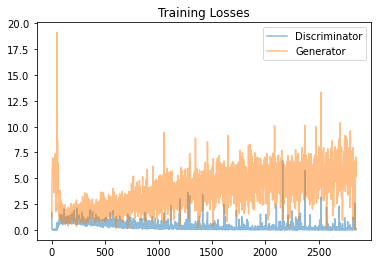

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

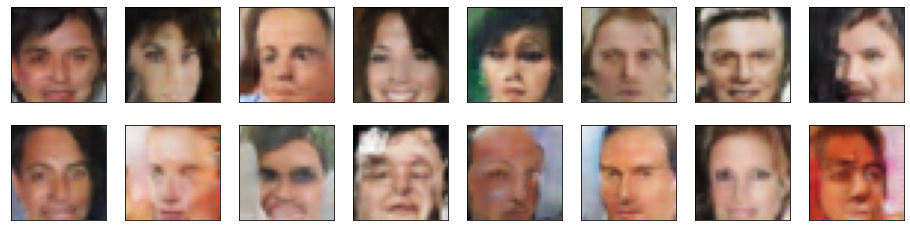

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

#### Observations:
- Most of the generated faces are white based on the biased dataset.
- Faces are distorted.
- The output faces lacks details that show the clear definition of parts of the faces.

#### Improvement points:
- From the dataset perspective:
    - Add different ethnicities to the dataset to produce more variety in the generated faces.
    - Zoom out a bit in the cropped dataset to include some clear face outline.
    - Try to have all the faces in the dataset have the same angle to fix some of the distortion.
- From the model perspective:
    - The model has not converged yet, so training it for longer might lead to a better result.
    - Increasing the dimension size of the convolution layers also will lead to a better result with more complexity.
    - We can have a dynamic learning rate rather than a constant one.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.